Gold Price Forecasting Using SARIMAX (2026 Outlook)

This project applies a seasonal ARIMA (SARIMAX) time-series model to monthly Gold Price data to generate a probabilistic forecast for 2026. Historical data through 2025 is used to capture long-term trends, seasonal dynamics, and persistence commonly observed in commodities markets.

The analysis emphasize stationarity testing, model diagnostics, and confidence intervals, providing a risk-aware outlook rather than point predictions alone. The goal is to demonstrate how econometric time-series methods can be used for macro-level market analysis and uncertainty assessment, not the trading signals.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


In [2]:
START_DATE = "2015-01-01"
END_DATE   = "2025-12-31"

TICKER = "GC=F"   # Gold futures. Use "GLD" if you prefer the ETF.

gold = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    auto_adjust=True,
    progress=False
)

# Monthly series (last trading day of each month)
gold_month = gold.resample("M").last().copy()

# Use adjusted Close (because auto_adjust=True, Close is already adjusted)
gold_month = gold_month.rename(columns={"Close": "Price"}, inplace=False)

# Keep only Price
df2 = gold_month[["Price"]].copy()

# Clean index
df2 = df2[~df2.index.duplicated(keep="last")].sort_index()
df2.index = pd.to_datetime(df2.index)

df2.head()


Price,Price
Ticker,GC=F
Date,
2015-01-31,1278.500000
2015-02-28,1212.599976
2015-03-31,1183.099976
2015-04-30,1182.400024
2015-05-31,1189.400024


In [3]:
adf_stat, pval, *_ = adfuller(df2["Price"].dropna())
print("ADF Statistic:", adf_stat)
print("p-value:", pval)


ADF Statistic: 5.39254562190972
p-value: 1.0


In [4]:
model = SARIMAX(
    df2["Price"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               GC=F   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -610.453
Date:                            Sat, 03 Jan 2026   AIC                           1230.907
Time:                                    03:03:36   BIC                           1244.177
Sample:                                01-31-2015   HQIC                          1236.284
                                     - 12-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0570      0.026     40.558      0.000       1.006       1.108
ma.L1         -0.9610      0.066   

In [5]:
forecast_steps = 12  # monthly forecasts for 2026

predictions_int = results.get_forecast(steps=forecast_steps)

pred_mean = predictions_int.predicted_mean.copy()
pred_ci = predictions_int.conf_int().copy()

pred_mean.name = "Forecast"
pred_ci.columns = ["Lower CI", "Upper CI"]

pred_mean.head(), pred_ci.head()


(2026-01-31    4586.768707
 2026-02-28    4731.961241
 2026-03-31    5048.268033
 2026-04-30    5300.687578
 2026-05-31    5480.508829
 Freq: ME, Name: Forecast, dtype: float64,
                Lower CI     Upper CI
 2026-01-31  4430.943137  4742.594278
 2026-02-28  4500.732248  4963.190234
 2026-03-31  4751.070588  5345.465478
 2026-04-30  4940.507692  5660.867465
 2026-05-31  5057.827316  5903.190342)

In [6]:
conf_df = pd.concat([df2["Price"], pred_mean, pred_ci], axis=1, join="outer")
conf_df = conf_df[~conf_df.index.duplicated(keep="last")].sort_index()
conf_df.head()


,GC=F,Forecast,Lower CI,Upper CI
2015-01-31,1278.500000,NaN,NaN,NaN
2015-02-28,1212.599976,NaN,NaN,NaN
2015-03-31,1183.099976,NaN,NaN,NaN
2015-04-30,1182.400024,NaN,NaN,NaN
2015-05-31,1189.400024,NaN,NaN,NaN


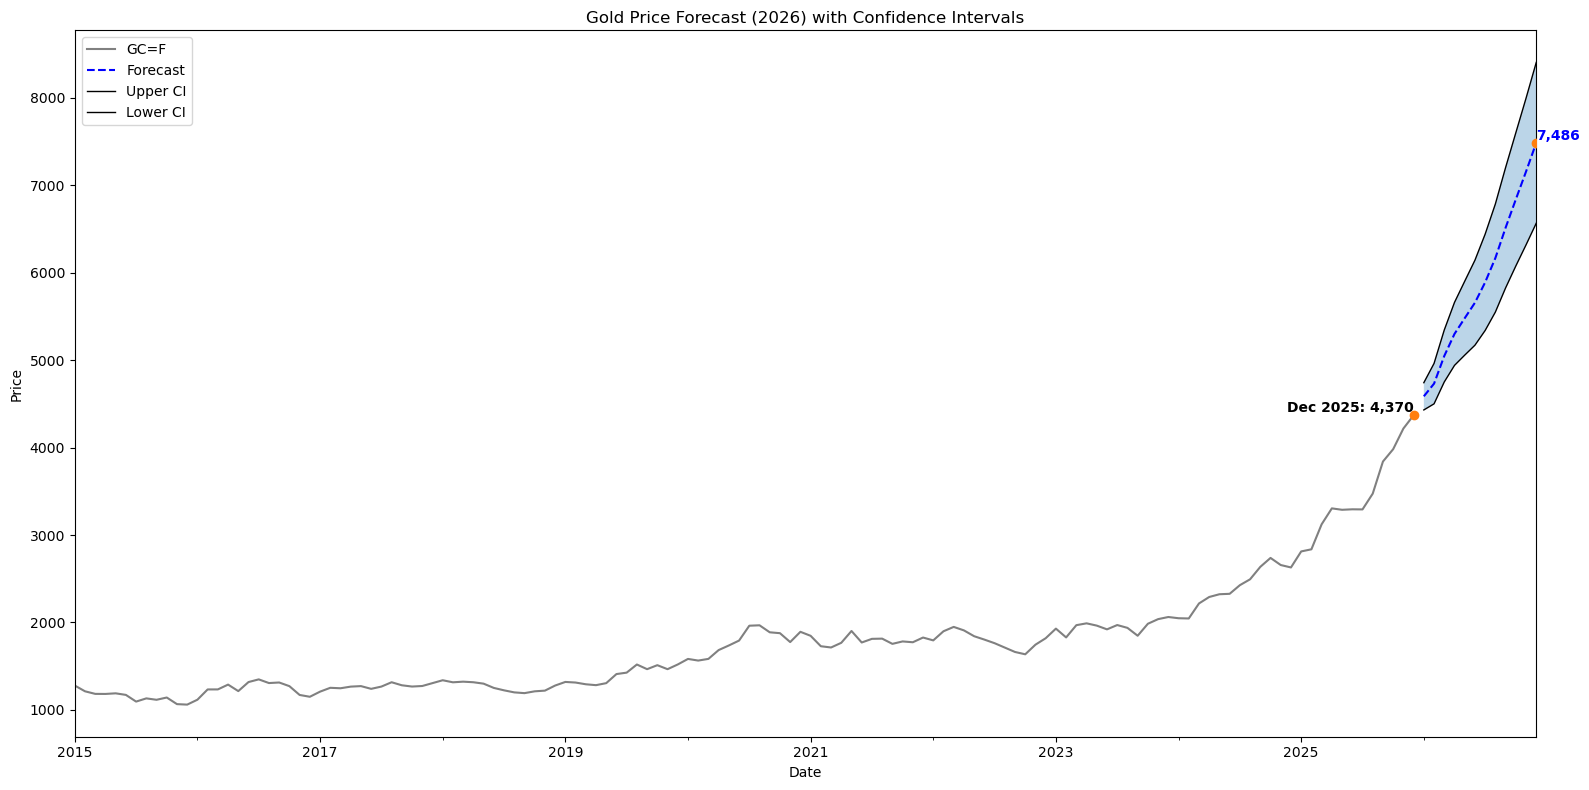

In [7]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)

# Actual
df2["Price"].plot(ax=ax1, label="Actual", color="grey")

# Forecast + CI (forecast period)
pred_mean.plot(ax=ax1, label="Forecast", color="blue", linestyle="--")
pred_ci["Upper CI"].plot(ax=ax1, label="Upper CI", color="black", linewidth=1)
pred_ci["Lower CI"].plot(ax=ax1, label="Lower CI", color="black", linewidth=1)

ax1.fill_between(
    pred_ci.index,
    pred_ci["Lower CI"],
    pred_ci["Upper CI"],
    alpha=0.3
)

# Annotate ONLY Dec 2025 actual + Dec 2026 forecast (as you wanted)
actual_2025_date = df2.index.max()
actual_2025_value = float(df2.loc[actual_2025_date, "Price"])

forecast_2026_date = pred_mean.index.max()
forecast_2026_value = float(pred_mean.loc[forecast_2026_date])

ax1.scatter([actual_2025_date, forecast_2026_date],
            [actual_2025_value, forecast_2026_value],
            zorder=5)

ax1.text(actual_2025_date, actual_2025_value,
         f"Dec 2025: {actual_2025_value:,.0f}",
         ha="right", va="bottom", fontweight="bold")

ax1.text(forecast_2026_date, forecast_2026_value,
         f"{forecast_2026_value:,.0f}",
         ha="left", va="bottom", fontweight="bold", color="blue")

ax1.set_title("Gold Price Forecast (2026) with Confidence Intervals")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")

plt.tight_layout()
plt.savefig("gold_forecast_2026.png", dpi=300, bbox_inches="tight")
plt.show()
